In [4]:
import numpy as np
from scipy import sparse

import h2o
import matplotlib as plt

#Import the Estimators
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator

#Import h2o grid search 
import h2o.grid 
from h2o.grid.grid_search import H2OGridSearch

## Set h2o memory limit, cpus, and initialize instance

In [5]:
h2o.init(nthreads = -1,max_mem_size = "12G")

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,38 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.3
H2O cluster version age:,15 days
H2O cluster name:,H2O_from_python_alex_poqixm
H2O cluster total nodes:,1
H2O cluster free memory:,12 Gb
H2O cluster total cores:,6
H2O cluster allowed cores:,6
H2O cluster status:,"locked, healthy"


# Load the processed data

In [6]:
X_train = sparse.load_npz("processed_data/raw_keyword_categorical_X_train_20k_feat.npz")
y_train = np.load("processed_data/raw_keyword_categorical_y_train.npy")
y_train = h2o.H2OFrame(y_train)
X_test = sparse.load_npz("processed_data/raw_keyword_categorical_test_processed_20k_feat.npz")

Parse progress: |█████████████████████████████████████████████████████████| 100%


## Convert the numpy sparse matrices to an H2o dataframe

In [7]:
X_train = h2o.H2OFrame(X_train)
X_test = h2o.H2OFrame(X_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [8]:
combined_train = X_train.cbind(y_train)

# Start H2o experiment
## Create train, val, test splits

In [9]:
train, valid, test = combined_train.split_frame([0.7, 0.15], seed=42)

In [10]:
print("train:%d valid:%d test:%d" % (train.nrows, valid.nrows, test.nrows))

train:5348 valid:1116 test:1149


In [11]:
y = "C110000"
ignore = ["C110000"]
x = list(set(train.names) - set(ignore))

# Generalized Linear Model

In [15]:
glm = H2OGeneralizedLinearEstimator(family = "binomial", seed=42, model_id = 'default_glm')

# Train the model

In [16]:
%%time
glm.train(x = x, y = y, training_frame = train, validation_frame = valid)

glm Model Build progress: |███████████████████████████████████████████████| 100%
CPU times: user 3.23 s, sys: 18.9 ms, total: 3.25 s
Wall time: 26.3 s


In [17]:
glm

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  default_glm


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,"Elastic Net (alpha = 0.5, lambda = 0.0125 )",16039,2491,12,py_6_sid_ba23




ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.07523328483593637
RMSE: 0.27428686595594837
LogLoss: 0.29188406315737087
Null degrees of freedom: 5347
Residual degrees of freedom: 2856
Null deviance: 7319.363845827336
Residual deviance: 3121.991939531239
AIC: 8105.991939531239
AUC: 0.9918733684203482
AUCPR: 0.990785195078425
Gini: 0.9837467368406965

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49898929365268085: 


,,0,1,Error,Rate
0,0,3008.0,21.0,0.0069,(21.0/3029.0)
1,1,67.0,2252.0,0.0289,(67.0/2319.0)
2,Total,3075.0,2273.0,0.0165,(88.0/5348.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.498989,0.980836,197.0
1,max f2,0.479263,0.976390,201.0
2,max f0point5,0.525479,0.987138,192.0
3,max accuracy,0.498989,0.983545,197.0
4,max precision,0.999013,1.000000,0.0
5,max recall,0.100213,1.000000,376.0
6,max specificity,0.999013,1.000000,0.0
7,max absolute_mcc,0.498989,0.966571,197.0
8,max min_per_class_accuracy,0.467229,0.974127,203.0
9,max mean_per_class_accuracy,0.498989,0.982088,197.0



Gains/Lift Table: Avg response rate: 43.36 %, avg score: 43.36 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010097,0.975974,2.306166,2.306166,1.000000,0.987920,1.000000,0.987920,0.023286,0.023286,130.616645,130.616645
1,,2,0.020007,0.962575,2.306166,2.306166,1.000000,0.970058,1.000000,0.979072,0.022855,0.046141,130.616645,130.616645
2,,3,0.030105,0.951165,2.306166,2.306166,1.000000,0.955997,1.000000,0.971333,0.023286,0.069426,130.616645,130.616645
3,,4,0.040015,0.940163,2.306166,2.306166,1.000000,0.945345,1.000000,0.964896,0.022855,0.092281,130.616645,130.616645
4,,5,0.050860,0.933089,2.306166,2.306166,1.000000,0.935825,1.000000,0.958697,0.025011,0.117292,130.616645,130.616645
5,,6,0.100037,0.881458,2.306166,2.306166,1.000000,0.910990,1.000000,0.935245,0.113411,0.230703,130.616645,130.616645
6,,7,0.150150,0.823360,2.297561,2.303295,0.996269,0.855694,0.998755,0.908695,0.115136,0.345839,129.756135,130.329451
7,,8,0.200075,0.757621,2.297529,2.301856,0.996255,0.792124,0.998131,0.879607,0.114705,0.460543,129.752912,130.185586
8,,9,0.300112,0.601334,2.267371,2.290361,0.983178,0.686068,0.993146,0.815094,0.226822,0.687365,126.737113,129.036095
9,,10,0.399963,0.536876,2.280254,2.287838,0.988764,0.549316,0.992052,0.748743,0.227684,0.915050,128.025447,128.783787




ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.15022633108808325
RMSE: 0.38759041666182004
LogLoss: 0.4689052798401027
Null degrees of freedom: 1115
Residual degrees of freedom: -1376
Null deviance: 1510.3251761879665
Residual deviance: 1046.5965846031095
AIC: 6030.5965846031095
AUC: 0.8518648709883783
AUCPR: 0.8076736511870224
Gini: 0.7037297419767565

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27255071980761153: 


,,0,1,Error,Rate
0,0,490.0,174.0,0.262,(174.0/664.0)
1,1,83.0,369.0,0.1836,(83.0/452.0)
2,Total,573.0,543.0,0.2303,(257.0/1116.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.272551,0.741709,260.0
1,max f2,0.203973,0.812500,303.0
2,max f0point5,0.552022,0.780543,159.0
3,max accuracy,0.552022,0.794803,159.0
4,max precision,0.995492,1.000000,0.0
5,max recall,0.016310,1.000000,399.0
6,max specificity,0.995492,1.000000,0.0
7,max absolute_mcc,0.552022,0.571477,159.0
8,max min_per_class_accuracy,0.312568,0.774336,243.0
9,max mean_per_class_accuracy,0.339475,0.778168,232.0



Gains/Lift Table: Avg response rate: 40.50 %, avg score: 40.27 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010753,0.977584,2.263274,2.263274,0.916667,0.984296,0.916667,0.984296,0.024336,0.024336,126.327434,126.327434
1,,2,0.020609,0.969108,2.469027,2.361678,1.000000,0.971849,0.956522,0.978343,0.024336,0.048673,146.902655,136.167757
2,,3,0.030466,0.957227,2.020113,2.251171,0.818182,0.963312,0.911765,0.973480,0.019912,0.068584,102.011263,125.117126
3,,4,0.040323,0.944403,2.244570,2.249558,0.909091,0.950179,0.911111,0.967784,0.022124,0.090708,124.456959,124.955752
4,,5,0.050179,0.935425,2.469027,2.292668,1.000000,0.938783,0.928571,0.962087,0.024336,0.115044,146.902655,129.266751
5,,6,0.100358,0.892728,2.380847,2.336757,0.964286,0.916179,0.946429,0.939133,0.119469,0.234513,138.084703,133.675727
6,,7,0.150538,0.822478,2.248578,2.307364,0.910714,0.860890,0.934524,0.913052,0.112832,0.347345,124.857775,130.736410
7,,8,0.200717,0.740104,1.763590,2.171421,0.714286,0.780818,0.879464,0.879994,0.088496,0.435841,76.359039,117.142067
8,,9,0.300179,0.540170,1.801722,2.048924,0.729730,0.633519,0.829851,0.798326,0.179204,0.615044,80.172208,104.892352
9,,10,0.400538,0.369812,1.036109,1.795154,0.419643,0.452108,0.727069,0.711578,0.103982,0.719027,3.610936,79.515353




Scoring History: 


,,timestamp,duration,iterations,negative_log_likelihood,objective
0,,2020-02-21 02:14:05,0.000 sec,0,3659.681923,0.684309
1,,2020-02-21 02:14:05,0.408 sec,1,2263.317071,0.523176
2,,2020-02-21 02:14:05,0.539 sec,2,2110.206628,0.516454
3,,2020-02-21 02:14:05,0.669 sec,3,2088.193748,0.516148
4,,2020-02-21 02:14:06,0.788 sec,4,2086.969533,0.516145
5,,2020-02-21 02:14:08,3.210 sec,5,1545.570655,0.495440
6,,2020-02-21 02:14:10,5.573 sec,6,1574.896717,0.494572
7,,2020-02-21 02:14:13,8.012 sec,7,1570.072433,0.494268
8,,2020-02-21 02:14:15,10.146 sec,8,1566.880807,0.494208
9,,2020-02-21 02:14:17,12.655 sec,9,1566.976016,0.494207


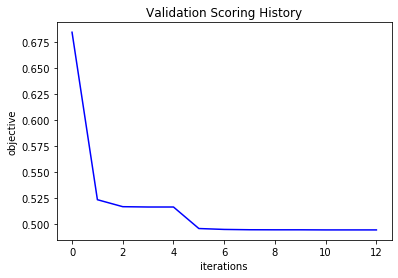

In [18]:
glm.plot()

In [19]:
# Save the model
default_glm_perf=glm.model_performance(valid)

In [82]:
predictions = glm.predict(X_test)

glm prediction progress: |████████████████████████████████████████████████| 100%


In [87]:
h2o.download_csv(predictions, "h2o_predictions.csv")

'/home/alex/Documents/mlbase/disaster_tweet_kaggle/h2o_predictions.csv'

# Random Forest

In [33]:
rf = H2ORandomForestEstimator(seed=42, model_id='default_random_forest', stopping_metric="logloss")
%time rf.train(x = x, y = y, training_frame = train, validation_frame = valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%
CPU times: user 4.36 s, sys: 89.4 ms, total: 4.45 s
Wall time: 1min 26s


In [34]:
rf

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  default_random_forest


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,57623.0,20.0,20.0,20.0,62.0,104.0,84.56




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.19336915110909958
RMSE: 0.43973759346808133
MAE: 0.3925908393071226
RMSLE: 0.3085379146477524
Mean Residual Deviance: 0.19336915110909958

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.19015258009680844
RMSE: 0.4360648806047197
MAE: 0.3874028518735531
RMSLE: 0.3093498343905469
Mean Residual Deviance: 0.19015258009680844

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2020-02-21 02:32:28,0.220 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2020-02-21 02:32:30,2.832 sec,1.0,0.459049,0.386630,0.210726,0.452430,0.380705,0.204693
2,,2020-02-21 02:32:36,8.047 sec,4.0,0.453329,0.393546,0.205507,0.439990,0.387881,0.193591
3,,2020-02-21 02:32:40,12.763 sec,7.0,0.449863,0.393618,0.202376,0.435324,0.385683,0.189507
4,,2020-02-21 02:32:45,17.497 sec,10.0,0.445139,0.390767,0.198149,0.435025,0.384445,0.189247
5,,2020-02-21 02:32:50,22.427 sec,13.0,0.444080,0.392234,0.197207,0.435727,0.386317,0.189858
6,,2020-02-21 02:32:55,27.331 sec,16.0,0.443278,0.392098,0.196496,0.436206,0.386227,0.190276
7,,2020-02-21 02:33:00,31.986 sec,19.0,0.442392,0.392769,0.195710,0.435709,0.386654,0.189842
8,,2020-02-21 02:33:04,36.304 sec,22.0,0.441707,0.393289,0.195105,0.435182,0.387148,0.189383
9,,2020-02-21 02:33:09,41.092 sec,25.0,0.441078,0.392290,0.194550,0.435872,0.387197,0.189985



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,C6988,674.736389,1.000000,0.055789
1,C2988,635.830444,0.942339,0.052572
2,C12666,599.993469,0.889226,0.049609
3,C18048,534.270996,0.791822,0.044175
4,C20337,523.677368,0.776121,0.043299
5,C5809,515.869934,0.764550,0.042653
6,C17899,389.146515,0.576739,0.032176
7,C13763,372.077271,0.551441,0.030764
8,C1244,303.219299,0.449389,0.025071
9,C12104,269.878113,0.399976,0.022314



See the whole table with table.as_data_frame()


In [23]:
rf_predictions = rf.predict(X_test)
h2o.download_csv(rf_predictions, "h2o_rf_predictions.csv")

drf prediction progress: |████████████████████████████████████████████████| 100%


'/home/alex/Documents/mlbase/disaster_tweet_kaggle/h2o_rf_predictions.csv'

# Gradient Boosting Machine

In [24]:
gbm= H2OGradientBoostingEstimator(seed=42, model_id='default_gbm')
%time gbm.train(x=x, y=y, training_frame=train, validation_frame = valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
CPU times: user 3.38 s, sys: 39.6 ms, total: 3.41 s
Wall time: 58.3 s


In [25]:
gbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  default_gbm


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,10765.0,5.0,5.0,5.0,8.0,18.0,12.46




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.18555545991517589
RMSE: 0.4307614884308669
MAE: 0.41196857982370155
RMSLE: 0.3047158605265398
Mean Residual Deviance: 0.18555545991517589

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 0.19053461199195945
RMSE: 0.4365027055952339
MAE: 0.41704306796730173
RMSLE: 0.31172648606912395
Mean Residual Deviance: 0.19053461199195945

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2020-02-21 02:23:38,0.202 sec,0.0,0.495574,0.491187,0.245594,0.491728,0.487390,0.241796
1,,2020-02-21 02:23:41,2.804 sec,1.0,0.492036,0.487509,0.242099,0.487420,0.483031,0.237578
2,,2020-02-21 02:23:42,4.025 sec,2.0,0.488636,0.483752,0.238765,0.484276,0.479537,0.234523
3,,2020-02-21 02:23:46,8.110 sec,6.0,0.478618,0.471806,0.229076,0.474995,0.468341,0.225620
4,,2020-02-21 02:23:50,12.317 sec,10.0,0.471117,0.462817,0.221952,0.468121,0.460007,0.219138
5,,2020-02-21 02:23:55,17.026 sec,14.0,0.465160,0.455311,0.216374,0.462592,0.452798,0.213992
6,,2020-02-21 02:23:59,21.336 sec,18.0,0.459951,0.448991,0.211555,0.458107,0.447262,0.209862
7,,2020-02-21 02:24:03,25.647 sec,22.0,0.454683,0.442597,0.206737,0.454228,0.441937,0.206323
8,,2020-02-21 02:24:08,29.847 sec,26.0,0.450606,0.437147,0.203046,0.450199,0.436432,0.202679
9,,2020-02-21 02:24:12,33.991 sec,30.0,0.446485,0.431790,0.199349,0.447679,0.432765,0.200417



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,C6988,98.587875,1.000000,0.058339
1,C18048,89.006790,0.902817,0.052669
2,C2988,74.358215,0.754233,0.044001
3,C5809,66.302368,0.672521,0.039234
4,C13763,63.670982,0.645830,0.037677
5,C20337,63.471596,0.643807,0.037559
6,C12666,62.094734,0.629841,0.036744
7,C17899,51.641930,0.523816,0.030559
8,C5824,44.475567,0.451126,0.026318
9,C18803,41.154308,0.417438,0.024353



See the whole table with table.as_data_frame()


In [29]:
gbm_predictions = gbm.predict(X_test)
h2o.download_csv(gbm_predictions, "h2o_gbm_predictions.csv")

gbm prediction progress: |████████████████████████████████████████████████| 100%


'/home/alex/Documents/mlbase/disaster_tweet_kaggle/h2o_gbm_predictions.csv'

# Tune GBM with H2O GridSearch

In [35]:
hyper_params = {'max_depth' : [1,3,5,6,7,8,9,10,12,13,15],
               }

gbm = H2OGradientBoostingEstimator(model_id='grid_gbm', ntrees=150,
    seed=42
    )

gbm_grid = H2OGridSearch(gbm, hyper_params,
                         grid_id = 'depth_gbm_grid',
                         search_criteria = {
                             "strategy":"Cartesian"})

%time gbm_grid.train(x=x, y=y, training_frame=train, validation_frame = valid)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
CPU times: user 10.5 s, sys: 346 ms, total: 10.8 s
Wall time: 36min 50s


In [37]:
sorted_gbm_depth = gbm_grid.get_grid(sort_by='rmsle',decreasing=True)
sorted_gbm_depth

     max_depth                model_ids                rmsle
0            1   depth_gbm_grid_model_1   0.3224827649796368
1            3   depth_gbm_grid_model_2  0.30232121979009974
2            5   depth_gbm_grid_model_3   0.2913567631294947
3            6   depth_gbm_grid_model_4  0.28836038236784867
4            7   depth_gbm_grid_model_5  0.28461026476140705
5            8   depth_gbm_grid_model_6   0.2823868335617112
6            9   depth_gbm_grid_model_7  0.28062313951357876
7           10   depth_gbm_grid_model_8   0.2788426691077111
8           12   depth_gbm_grid_model_9   0.2769447546419298
9           13  depth_gbm_grid_model_10   0.2761036608424165
10          15  depth_gbm_grid_model_11  0.27440026981295257


In [ ]:
gbm = H2OGradientBoostingEstimator(max_depth=15, ntrees=80,
    seed=42, model_id='tuned_gbm'
    )
%time gbm.train(x=x, y=y, training_frame=train, validation_frame = valid)
gbm.plot(metric='auc')